# **SST Validation Workflows with ValidOcean**

#### **Description:**
This tutorial notebook introduces a typical sea surface temperature validation workflow in ValidOcean using the ModelValidator class.


To demonstrate a typical sea surface temperature validation workflow, we will use outputs from the **National Oceanography Centre's** Near-Present-Day global 1-degree (eORCA1-NPD-ERA5v1) ocean sea-ice simulation introduced in **Example 1**, which represents the historical period from 1976 - present.

For more details on this model configuration and the available outputs, users should explore the Near-Present-Day documentation [here](https://noc-msm.github.io/NOC_Near_Present_Day/).

### **Contact:**
Ollie Tooth (oliver.tooth@noc.ac.uk)

In [1]:
# -- Import required libraries -- #
import xarray as xr
from ValidOcean import ModelValidator

/home/otooth/miniconda3/envs/env_nemo_validation/lib/python3.12/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


#### **Accessing & Preparing Example Ocean Model Data**

We will begin by using the [xarray](https://xarray.dev) Python library to load an example dataset from the eORCA1-NPD-ERA5v1 outputs available on the [JASMIN Object Store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/). 

As in Example 1, we will load the [NEMO](https://www.nemo-ocean.eu) ocean model domain variables and then we will load monthly mean sea surface temperatures for the global domain.

Before creating a ``ModelValidator()`` object, we need to update our ocean model coordinate variables to conform to the standard names used by ValidOcean & add a land/ocean mask file for regridding.

In [2]:
# Define url to domain store:
url_domain = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-era5v1/domain/"
ds_domain = xr.open_zarr(url_domain, consolidated=True)

# Define url to sea surface temperature (tos_con) store:
url_tos_con = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-era5v1/T1m/tos_con/"
ds_tos_con = xr.open_zarr(url_tos_con, consolidated=True)

# Updating model coords:
ds_tos_con = ds_tos_con.rename({'nav_lat': 'lat', 'nav_lon': 'lon', 'time_counter': 'time'})
# Adding a 2-D land/ocean mask to our Dataset:
ds_tos_con['mask'] = ds_domain['tmaskutil'].squeeze()

ds_tos_con

<xarray.Dataset> Size: 281MB
Dimensions:        (y: 331, x: 360, time: 585)
Coordinates:
    lat            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    lon            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 5kB 1976-01-16T12:00:00 ... 2024-09-16
    time_counter   float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time, y, x) float32 279MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    mask           (y, x) int8 119kB dask.array<chunksize=(331, 360), meta=np.ndarray>

#### **Creating A ModelValidator**

Now let's create a new ``ModelValidator()`` object using our monthly sea surface temperature data. 

In [ ]:
# Creating a new ModelValidator object:
mv = ModelValidator(mdl_data=ds_tos_con)
mv


<ModelValidator>

-- Model Data --

<xarray.Dataset> Size: 281MB
Dimensions:        (y: 331, x: 360, time: 585)
Coordinates:
    lat            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    lon            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_centered  (time) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 5kB 1976-01-16T12:00:00 ... 2024-09-16
    time_counter   float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time, y, x) float32 279MB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    mask           (y, x) int8 119kB dask.array<chunksize=(331, 360), meta=np.ndarray>

-- Observations --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Results --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
    *empty*

-- Stats --

<xarray.Dataset> Size: 0B
Dimensions:  ()
Data variables:
   

#### **Plotting (Model - Observations) Sea Surface Temperature Bias**

Consider the typical scenario where we have just completed a ocean model simulation and would now like to know how well the surface properties in our hindcast represent the real ocean. A common starting point is to calculate the difference or bias between the climatologies of sea surface temperature (SST) simulated in the model and recorded in observations. 

We can divide this validation workflow into several steps:

1. **Select & load our ocean observation dataset**

- We will use the 1991-2020 climatology of the NOAA High-resolution Blended Analysis of Daily SST (OISSTv2) product.

2. **Load & subset our ocean model dataset** 

- Only a temporal subsetting is needed to match the observations since OISSTv2 has global coverage.

3. **Calculate the SST climatology from our ocean model dataset.**

4. **Regrid either the model climatology onto the observations grid or vice versa** 

- We regrid the observations climatology onto the model grid using bilinar interpolation.

5. **Calculate the (model - observation) error & aggregated statistics** 

- We return the MAE, MSE and RMSE.

6. **Plot the (model - observation) SST error** 

- We also include the model & observation SST climatologies.

The true value of ValidOcean is that all of the steps are perfomed for you by using the **plot_sst_error()** method of the ModelValidator...

array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object)

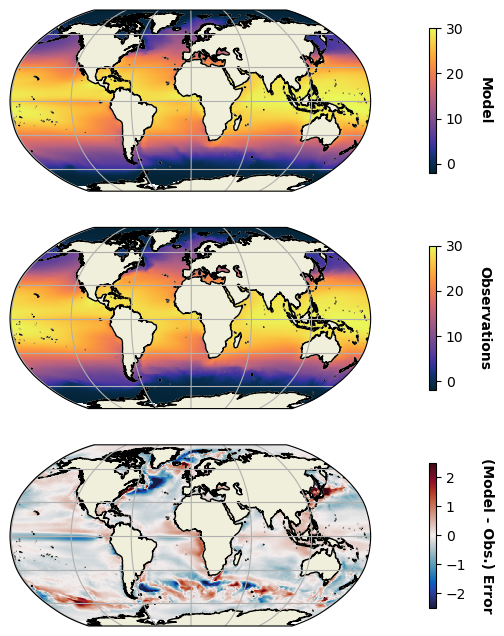

In [4]:
mv.plot_sst_error(sst_name='tos_con',
                  obs_name='OISSTv2',
                  time_bounds='1991-2020',
                  freq='total',
                  regrid_to='model',
                  method='bilinear',
                  source_plots=True,
                  stats=True,
                  )

#### **Results of our Validation Workflow**

In addition to the plot shown above, calling the ``plot_sst_error()`` method has populated the ``.obs``, ``.results`` and ``.stats`` attributes with the results of our validation workflow.

Let's start by exploring the observational data which has been added to the ``.obs`` attribute. 

Here, we can see that a new DataArray ``tos_con_oisstv2`` has been added to the observations dataset as a result of regridding the OISSTv2 (1991-2020) climatology onto our original model grid using bilinear interpolation (shown in panel (b) above).

In [5]:
mv.obs

<xarray.Dataset> Size: 2MB
Dimensions:               (y: 331, x: 360)
Coordinates:
    lat_oisstv2           (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    lon_oisstv2           (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter_oisstv2  float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    tos_con_oisstv2       (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>

We can see that the model - observation SST error (``tos_con_error`` shown in panel (c) above) has been included alongside the original ocean model SST ``tos_con`` in the ``.results`` attribute.

In [6]:
mv.results

<xarray.Dataset> Size: 3MB
Dimensions:        (obs: 1, y: 331, x: 360)
Coordinates:
  * obs            (obs) object 8B 'OISSTv2'
    lat            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    lon            (y, x) float64 953kB dask.array<chunksize=(331, 360), meta=np.ndarray>
    time_counter   float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    tos_con_error  (obs, y, x) float32 477kB dask.array<chunksize=(1, 331, 360), meta=np.ndarray>
    tos_con        (y, x) float32 477kB dask.array<chunksize=(331, 360), meta=np.ndarray>

Finally, we can also compute the aggregate statistics quantifying the error between our ocean model & the OISSTv2 SST climatology by calling ``.compute()`` on the ``.stats`` attribute.

In [7]:
mv.stats.compute()

<xarray.Dataset> Size: 16B
Dimensions:                 ()
Coordinates:
    time_counter            float32 4B 0.0
Data variables:
    Mean Absolute Error     float32 4B 0.3241
    Mean Square Error       float32 4B 0.2731
    Root Mean Square Error  float32 4B 0.5226

#### **Validation Without Visualisation**

To perform our SST validation workflow without visualising the results, we can alternatively use the ``.compute_sst_error()`` method, which returns all of the results discussed above without the matplotlib axes object.

To demonstrate this method, we will create a new ``ModelValidator`` object using a regional North Atlantic subdomain of our ocean model dataset and perform a seasonal SST validation workflow as follows... 

In [8]:
# Creating a regional ModelValidator object:
mv_regional = ModelValidator(mdl_data=ds_tos_con.isel(x=slice(200, 300), y=slice(220, None)))

In [9]:
mv_regional.compute_sst_error(sst_name='tos_con',
                              obs_name='OISSTv2',
                              time_bounds='1991-2020',
                              freq='seasonal',
                              regrid_to='model',
                              method='bilinear',
                              stats=True,
                              )


<ModelValidator>

-- Model Data --

<xarray.Dataset> Size: 26MB
Dimensions:        (y: 111, x: 100, time: 585)
Coordinates:
    lat            (y, x) float64 89kB dask.array<chunksize=(111, 100), meta=np.ndarray>
    lon            (y, x) float64 89kB dask.array<chunksize=(111, 100), meta=np.ndarray>
    time_centered  (time) datetime64[ns] 5kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 5kB 1976-01-16T12:00:00 ... 2024-09-16
    time_counter   float32 4B 0.0
Dimensions without coordinates: y, x
Data variables:
    tos_con        (time, y, x) float32 26MB dask.array<chunksize=(1, 111, 100), meta=np.ndarray>
    mask           (y, x) int8 11kB dask.array<chunksize=(111, 100), meta=np.ndarray>

-- Observations --

<xarray.Dataset> Size: 355kB
Dimensions:               (season_oisstv2: 4, y: 111, x: 100)
Coordinates:
  * season_oisstv2        (season_oisstv2) object 32B 'DJF' 'JJA' 'MAM' 'SON'
    lat_oisstv2           (y, x) float64 89kB dask.arr

If we did want to visualise the results of our validation workflow, we could modify our previous example of the ``plot_sst_error`` method as follows..

/dssgfs01/working/otooth/Diagnostics/ValidOcean/ValidOcean/plotting.py:77: RuntimeWarning: source_plots = True is only available where freq = 'total'. Using source_plots = False.
  warnings.warn("source_plots = True is only available where freq = 'total'. Using source_plots = False.", RuntimeWarning)


array([<GeoAxes: >, <GeoAxes: >, <GeoAxes: >, <GeoAxes: >], dtype=object)

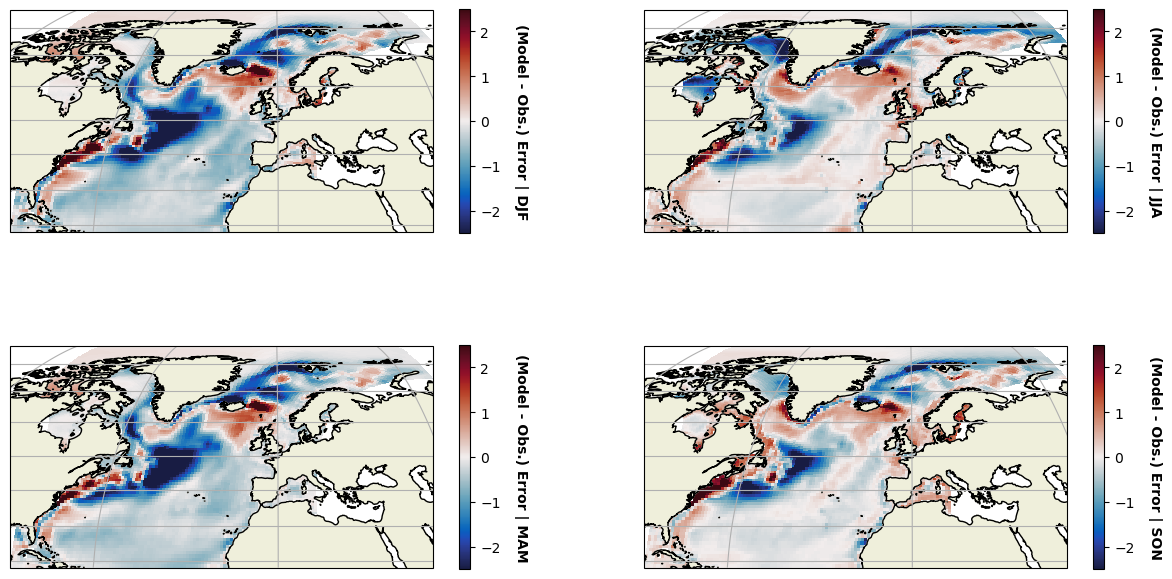

In [10]:
mv_regional.plot_sst_error(sst_name='tos_con',
                           obs_name='OISSTv2',
                           time_bounds='1991-2020',
                           freq='seasonal',
                           regrid_to='model',
                           method='bilinear',
                           stats=True,
                           )

#### **Next Steps...**

In this tutorial, we have seen how to perform a typical ocean model validation worfklow for sea surface temperature data using the ModelValidator object.

Next, we will explore how to use the ModelValidator to validate sea ice data, including aggregated diagnostics (e.g., sea ice area), in the **ex3_sea_ice_validation_workflow.ipynb** notebook.